In [1]:
pip install scipy


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install scikit-learn


   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ------------ --------------------------- 2.6/8.7 MB 14.3 MB/s eta 0:00:01
   -------------------------------------- - 8.4/8.7 MB 20.7 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 18.0 MB/s  0:00:00

   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ---------------

In [4]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


Starting Black-Scholes model analysis on 'cleaned_nifty_options.csv'...

Model Parameters
Assumed Risk-Free Rate (r): 7.00%
Assumed Historical Volatility (σ): 14.00%
Data Recorded Date: 2025-08-06

R-squared (R²): 0.9930
Overall Model Accuracy Metrics
Mean Absolute Error (MAE): ₹39.98
Root Mean Squared Error (RMSE): ₹64.27


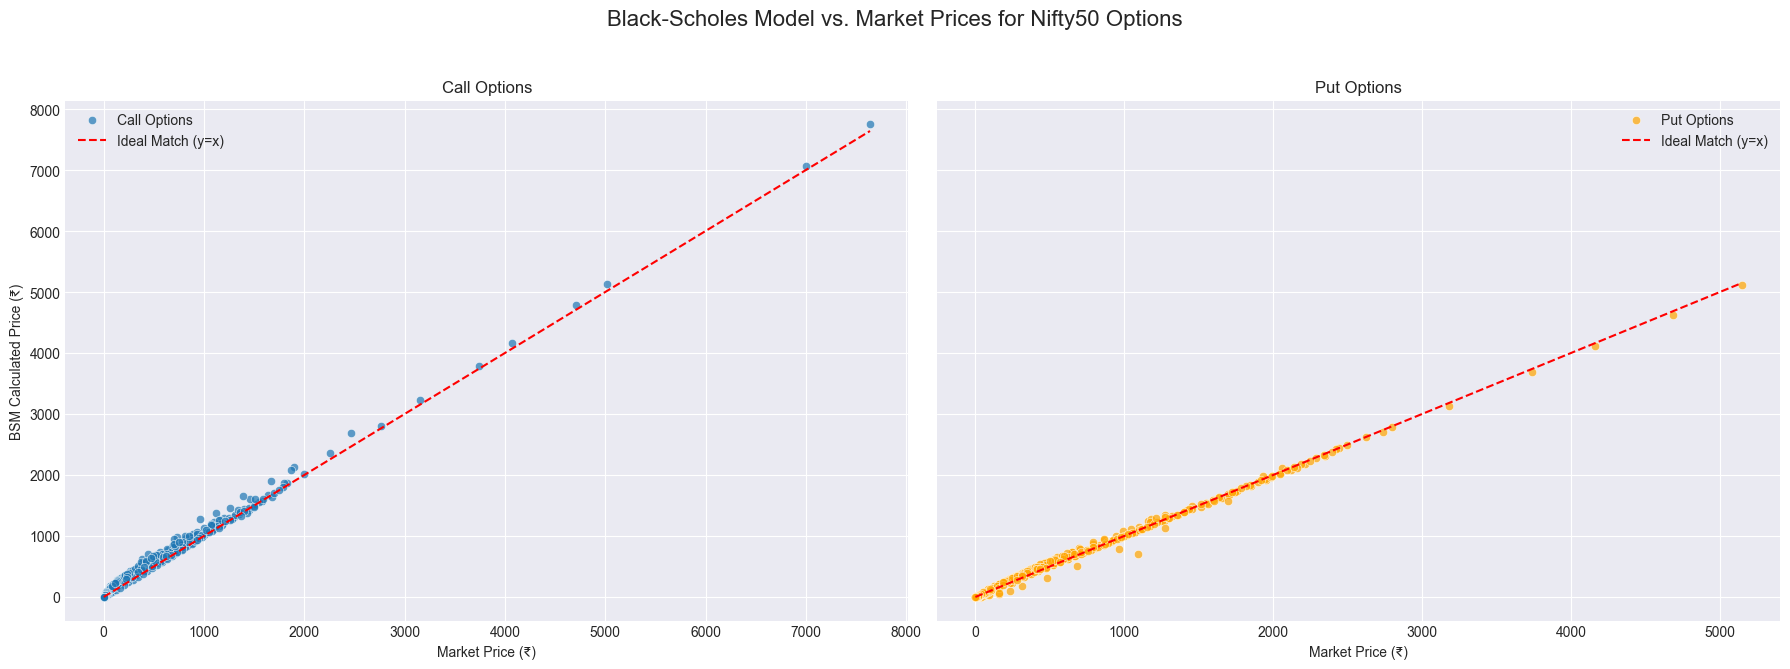

In [10]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

def black_scholes(S, K, T, r, sigma, option_type='call'):
    """
    Calculates the Black-Scholes option price.
    
    Parameters:
    S (float): Current price of the underlying asset (Spot Price)
    K (float): Strike price of the option
    T (float): Time to expiration in years
    r (float): Risk-free interest rate (annual)
    sigma (float): Volatility of the underlying asset (annual)
    option_type (str): 'call' or 'put'
    
    Returns:
    float: The theoretical option price.
    """
    if T <= 0:
        return max(0.0, S - K) if option_type == 'call' else max(0.0, K - S)
            
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        price = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    elif option_type == 'put':
        price = (K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1))
    else:
        raise ValueError("Invalid option type. Choose 'call' or 'put'.")
    return price

def run_bsm_analysis(input_filename='cleaned_nifty_options.csv'):
    """
    Loads cleaned options data and assesses the accuracy of the BSM.
    """
    print(f"Starting Black-Scholes model analysis on '{input_filename}'...")
    
    #Step 1: Load Data and Set Parameters
    try:
        df = pd.read_csv(input_filename)
        df['Expiry_Date'] = pd.to_datetime(df['Expiry_Date'])
    except FileNotFoundError:
        print(f"Error: Cleaned data file '{input_filename}' not found.")
        print("Please run the data cleaning script first to generate this file.")
        return

    RISK_FREE_RATE = 0.07 
    HISTORICAL_VOLATILITY = 0.14 
    DATA_RECORDED_DATE = datetime(2025, 8, 6)

    print("\nModel Parameters")
    print(f"Assumed Risk-Free Rate (r): {RISK_FREE_RATE:.2%}")
    print(f"Assumed Historical Volatility (σ): {HISTORICAL_VOLATILITY:.2%}")
    print(f"Data Recorded Date: {DATA_RECORDED_DATE.strftime('%Y-%m-%d')}\n")

    # Step 2: Calculate BSM Prices and Errors
    results = []
    for index, row in df.iterrows():
      
        T = (row['Expiry_Date'] - DATA_RECORDED_DATE).days / 365.0
        
        bsm_price = black_scholes(
            S=row['Spot_Price'],
            K=row['Strike_Price'],
            T=T,
            r=RISK_FREE_RATE,
            sigma=HISTORICAL_VOLATILITY,
            option_type=row['Option_Type']
        )
        
        error = bsm_price - row['Market_Price']
        
        result_row = row.to_dict()
        result_row['BSM_Price'] = bsm_price
        result_row['Error'] = error
        results.append(result_row)

    results_df = pd.DataFrame(results)

    # Step 3: Analyze and Display Results
    mae = np.mean(np.abs(results_df['Error']))
    rmse = np.sqrt(np.mean(results_df['Error'] ** 2))
    y_true = results_df['Market_Price']
    y_pred = results_df['BSM_Price']
    r_squared = r2_score(y_true, y_pred)
    print(f"R-squared (R²): {r_squared:.4f}")
    print("Overall Model Accuracy Metrics")
    print(f"Mean Absolute Error (MAE): ₹{mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): ₹{rmse:.2f}")

    # Step 4: Visualization
    plt.style.use('seaborn-v0_8-darkgrid')
    
    calls = results_df[results_df['Option_Type'] == 'call']
    puts = results_df[results_df['Option_Type'] == 'put']

    fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
    fig.suptitle('Black-Scholes Model vs. Market Prices for Nifty50 Options', fontsize=16)

    sns.scatterplot(data=calls, x='Market_Price', y='BSM_Price', ax=axes[0], label='Call Options', alpha=0.7)
    axes[0].plot([0, calls['Market_Price'].max()], [0, calls['Market_Price'].max()], 
                 color='red', linestyle='--', label='Ideal Match (y=x)')
    axes[0].set_title('Call Options')
    axes[0].set_xlabel('Market Price (₹)')
    axes[0].set_ylabel('BSM Calculated Price (₹)')
    axes[0].legend()
    axes[0].grid(True)

    sns.scatterplot(data=puts, x='Market_Price', y='BSM_Price', ax=axes[1], color='orange', label='Put Options', alpha=0.7)
    axes[1].plot([0, puts['Market_Price'].max()], [0, puts['Market_Price'].max()], 
                 color='red', linestyle='--', label='Ideal Match (y=x)')
    axes[1].set_title('Put Options')
    axes[1].set_xlabel('Market Price (₹)')
    axes[1].set_ylabel('')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# our main code
if __name__ == "__main__":
    run_bsm_analysis()

